## **DATASET CREATION**

In [ ]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from nltk.corpus import stopwords
from langdetect import detect
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from langdetect import detect
import spacy
from tqdm import tqdm
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
import os
import matplotlib.pyplot as plt
import little_mallet_wrapper as lmw

In [2]:
politicians= pd.read_csv('politicians_data/politicians_classified.csv')
politicians.drop(politicians.columns[-1], axis=1, inplace=True)

### Preprocessing

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words_italian = set(stopwords.words('italian'))
stop_words_english = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


nlp_it = spacy.load('it_core_news_sm')
nlp_en = spacy.load('en_core_web_sm')

def preprocess_text(text):
    try:
        lang = detect(text)
    except:
        lang = 'unknown'
    
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    
    if lang == 'it':  # Italian
        doc = nlp_it(text.lower())
        true_tokens = [token.lemma_ for token in doc 
                      if token.text not in stop_words_italian and len(token.text) > 2 and token.pos_ not in ('VERB', 'ADV','AUX')]
    
    elif lang == 'en':  # English
        doc = nlp_en(text.lower())
        true_tokens = [token.lemma_ for token in doc 
                      if token.text not in stop_words_english and len(token.text) > 2 and token.pos_ not in ('VERB', 'ADV')]
    
    else: 
        tokens = word_tokenize(text.lower())
        true_tokens = [lemmatizer.lemmatize(word) for word in tokens if len(word) > 2]
    
    return true_tokens

politicians_tweets = politicians['Content']

tqdm.pandas(desc="Processing tweets")
politicians['processed_tweet'] = politicians_tweets.progress_apply(lambda x: preprocess_text(x))


### We divide the politicians in separate datasets with respect to their belief and perform topic modeling using gensim LDA and the and the little MALLET wrapper LDA topic modeling https://github.com/maria-antoniak/little-mallet-wrapper/blob/master/demo.ipynb

### The difference across these two approaches is the following: Gensim typically uses Variational Bayes, which is a different approach compared to MALLET's Gibbs sampling.

### Let's start with the right wing politicians and the gensim LDA approach

In [ ]:
right_wing=politicians[politicians['ideology_num'] == 3]
right_wing_processed = right_wing['processed_tweet']
dictionary_right = corpora.Dictionary(right_wing['processed_tweet'])
corpus_right = [dictionary_right.doc2bow(text) for text in right_wing['processed_tweet']]

### We explore which is the best number of topics by computing coherence scores for each LDA model

In [5]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model =LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10, random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [6]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary_right, corpus=corpus_right, texts=right_wing_processed, start=3, limit=45, step=3)

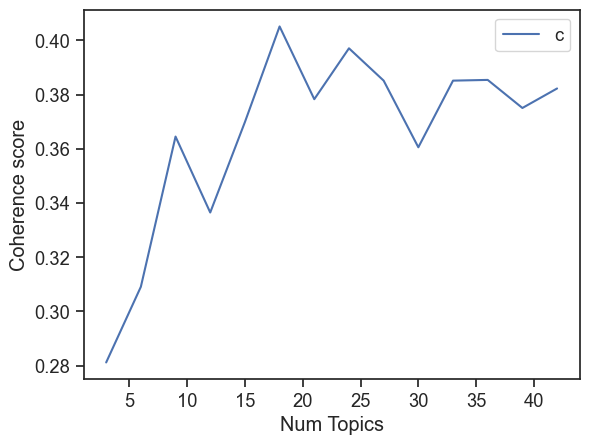

In [7]:
limit=45; start=3; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num -s")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### Let's see now the topics obtained from the LDA model with the optimal number of topics

In [8]:
x_list= list(x)
best_num_topics_right_lda = x_list[np.argmax(coherence_values)]
lda_model_right= LdaModel(corpus=corpus_right, id2word=dictionary_right, num_topics=best_num_topics_right_lda, passes=10, random_state=42)
for idx, topic in lda_model_right.print_topics(-1):
    print(f"Topic {idx}: {topic}")

Topic 0: 0.033*"anno" + 0.020*"vita" + 0.016*"famiglia" + 0.015*"vittima" + 0.014*"abbraccio" + 0.014*"preghiera" + 0.013*"figlio" + 0.010*"ragazzo" + 0.010*"violenza" + 0.010*"ogni"
Topic 1: 0.023*"disabilità" + 0.019*"infrastruttura" + 0.011*"troppo" + 0.011*"napolo" + 0.010*"mercato" + 0.010*"saluto" + 0.010*"mondiale" + 0.009*"stazione" + 0.009*"integrazione" + 0.009*"italy"
Topic 2: 0.060*"sinistra" + 0.020*"elettorale" + 0.019*"campagna" + 0.018*"italiano" + 0.012*"legge" + 0.011*"crescita" + 0.010*"senza" + 0.010*"problema" + 0.010*"ogni" + 0.010*"poltrona"
Topic 3: 0.030*"firma" + 0.018*"alto" + 0.017*"testa" + 0.015*"processo" + 0.015*"opera" + 0.014*"straordinario" + 0.014*"signore" + 0.013*"calabria" + 0.012*"locale" + 0.011*"palermo"
Topic 4: 0.031*"solidarietà" + 0.021*"minaccia" + 0.020*"giornalista" + 0.019*"gente" + 0.017*"insulto" + 0.012*"vergognoso" + 0.012*"autonomo" + 0.011*"libero" + 0.011*"contento" + 0.010*"coraggio"
Topic 5: 0.038*"Italia" + 0.027*"paese" + 0.0

### Let's see a representation of the topics

In [ ]:
pyLDAvis.enable_notebook()
LDAvis_data_filepath_right = os.path.join('./results/ldavis_prepared_right'+str(best_num_topics_right_lda))

if 1 == 1:
    LDAvis_prepared_right = gensimvis.prepare(lda_model_right, corpus_right, dictionary_right)
    with open(LDAvis_data_filepath_right, 'wb') as f:
        pickle.dump(LDAvis_prepared_right, f)

with open(LDAvis_data_filepath_right, 'rb') as f:
    LDAvis_prepared_right = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared_right, './results/ldavis_prepared_right'+ str(best_num_topics_right_lda) +'.html')

LDAvis_prepared_right

### Let's see now which topic is assigned to each tweet 

In [10]:
def format_topics_sentences(ldamodel, corpus):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel.get_document_topics(corpus)):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = pd.concat([sent_topics_df, pd.DataFrame([[int(topic_num), round(prop_topic, 4), topic_keywords]], columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])], ignore_index=True)
            else:
                break

    # Add original text to the end of the output
    return sent_topics_df


In [11]:
f_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_right, corpus=corpus_right)

# Format
df_dominant_topic = f_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords
0,0,1,0.4607,"disabilità, infrastruttura, troppo, napolo, me..."
1,1,2,0.2512,"sinistra, elettorale, campagna, italiano, legg..."
2,2,10,0.9475,"governo, settimana, piano, vaccinale, paese, e..."
3,3,15,0.4827,"lega, grazie, Roma, cittadinanza, lavoro, salv..."
4,4,14,0.7410,"europeo, libertà, diritto, presidente, parlame..."
5,5,1,0.7229,"disabilità, infrastruttura, troppo, napolo, me..."
6,6,16,0.5351,"clandestino, ministro, sbarco, confine, lamorg..."
7,7,12,0.7256,"governo, italiano, centrodestra, paese, litali..."
8,8,4,0.5030,"solidarietà, minaccia, giornalista, gente, ins..."
9,9,1,0.4509,"disabilità, infrastruttura, troppo, napolo, me..."


### Let's approach now the task with the LDA implementation in the MALLLET wrapper

In [ ]:
MALLET_path= '/opt/local/bin/mallet'
output_directory = '/Users/filippofocaccia/Desktop/nlp-project/politicians_data/politicians_filtered'
right_wing['processed_tweet_MALLET']=right_wing['processed_tweet'].apply(lambda x: ' '.join(x))
data_mallet= [t for t in right_wing['processed_tweet_MALLET'].tolist()]


### Let's find the optimal number of topics

In [13]:
def calculate_coherence(topic_keys, training_data, coherence_type='c_v', top_n=10):
    
    tokenized_texts = [doc.split() for doc in training_data]
    
    dictionary = Dictionary(tokenized_texts)
    
    topics_list = [[word for word in topic[:top_n]] for topic in topic_keys]
    
    coherence_model = CoherenceModel(
        topics=topics_list,
        texts=tokenized_texts,
        dictionary=dictionary,
        coherence=coherence_type
    )
    
    coherence_score = coherence_model.get_coherence()
    
    try:
        topic_coherences = coherence_model.get_coherence_per_topic()
    except:
        topic_coherences = [coherence_score] * len(topics_list)
    
    return coherence_score, topic_coherences

In [14]:

def find_optimal_topics(path_to_mallet, output_directory_path, training_data, 
                              topic_range=(5, 50, 5), coherence_type='c_v', top_n=10):
    
    num_topics_list = list(range(topic_range[0], topic_range[1] + 1, topic_range[2]))
    coherence_scores = []

    path_to_training_data = output_directory_path + '/coherence_training.txt'
    
    lmw.import_data(path_to_mallet,
                   path_to_training_data,
                   output_directory_path + '/coherence.training',
                   training_data)
    
    for num_topics in num_topics_list:
        output_directory_num = os.path.join(output_directory_path, str(num_topics))
        if not os.path.exists(output_directory_num):
            os.mkdir(output_directory_num)
            output_directory_path_num = output_directory_num
        else:
            output_directory_path_num = output_directory_num
        print(f"Training model with {num_topics} topics...")
        
        topic_keys, _ = lmw.quick_train_topic_model(path_to_mallet,
                             output_directory_path_num,
                            num_topics,
                            training_data)
        
        coherence_score, _ = calculate_coherence(
topic_keys, training_data, coherence_type, top_n)
        
        coherence_scores.append(coherence_score)
        print(f"Number of topics: {num_topics}, {coherence_type.upper()} Coherence: {coherence_score:.4f}")
    
    return num_topics_list, coherence_scores


In [ ]:
num_topics_list, coherence_scores = find_optimal_topics(
    MALLET_path,
    output_directory,
    data_mallet,
    topic_range=(3, 40, 5),
    coherence_type='c_v',
    top_n=10
)


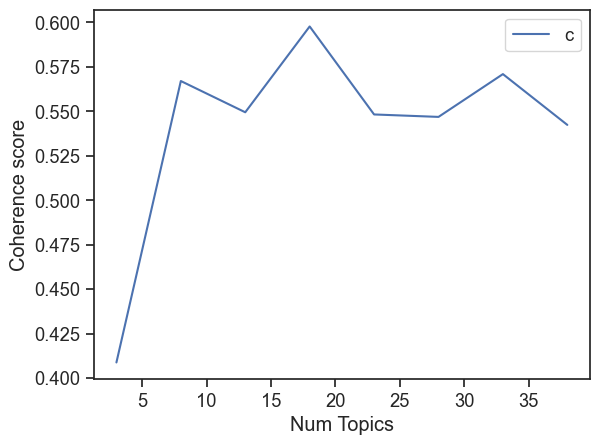

In [16]:
plt.plot(num_topics_list, coherence_scores)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_scores"), loc='best')
plt.show()

### We now compute the LDA MALLET model with the optimal number of topics

In [ ]:
best_num_topics_MALLET_right= num_topics_list[coherence_scores.index(max(coherence_scores))]
topic_keys, topic_distributions = lmw.quick_train_topic_model(MALLET_path, 
                                                              output_directory, 
                                                              best_num_topics_MALLET_right, 
                                                              data_mallet)

In [ ]:
topics_right = pd.DataFrame()
text={}
for i, t in enumerate(topic_keys):
    text[i] = ' '.join(t)  # Assign as a single-row DataFrame column
    print(i, '\t', text[i])

topics_right['TopicNumber'] = text.keys()
topics_right['TopicWords'] = text.values()
macros = {0: [1, 4, 11, 12, 13, 15, 17], 1: [0, 5, 6, 14], 2: [2, 3, 7, 8, 9, 10, 16]}
topics=[' National Values and Social Issues',' Economic and Development Issues','Governance and International Relations']
assigned_topics = []
for index,row in topics_right.iterrows():
    if index in macros[0]:
        assigned_topics.append(topics[0])
    elif index in macros[1]:
        assigned_topics.append(topics[1])
    else:
        assigned_topics.append(topics[2])
topics_right['MacroTopic'] = assigned_topics



0 	 nucleare sicuro generazione pulito energetico ultimo energia futuro ricerca gas del ambiente rinnovabile que ideologico mondo fonte para mozione indipendente
1 	 anno donna vita uomo vittima forza famiglia giustizia preghiera due giorno solidarietà italiano tutto memoria grazie pensiero polizia onore servizio
2 	 europeo guerra pace difesa paese politica estero ministro litalia Italia comune russo tema sostegno internazionale presidente protagonista economico Russia ucraino
3 	 Roma sindaco lega città grazie Milano regione cittadino candidato tanto territorio capitale amico calabria squadra amministratore elettorale grande futuro dopo
4 	 governo attività riapertura misura italiano lavoro coprifuoco libertà chiusura senza sicurezza vita cittadino ministro pass buonsenso ristorante zona sanitario greenpass
5 	 famiglia impresa gas bolletta governo crisi caro luce primo economico miliardo lega difficoltà energetico costo prezzo sostegno tempo aiuto proposta
6 	 lavoro tassa impresa l

In [64]:
topics_right
topics_right.to_csv('politicians_data/topics_right.csv', index=False)

- National Values and Social Issues
    This narrative centers on the protection of traditional "famiglia" (family) structures and "valori" (values), with frequent references to "vita" (life), "donna" (woman), "uomo" (man), and "preghiera" (prayer). Right-wing politicians emphasize "solidarietà" (solidarity) and "memoria" (memory) as pillars of Italian identity, constructing a narrative that places family at the nation's core.
    Care for vulnerable populations appears through discussions of "casa" (home), "mamma" (mother), "bimbo" (child), "papà" (father), "figlio" (son/child), "anziano" (elderly), and people with "disabilità" (disabilities), but notably within traditional family frameworks rather than through state welfare expansion.
    Concerns about "libertà" (freedom) and "diritti" (rights) are framed specifically in opposition to "islamico" (Islamic) extremism, "terrorismo" (terrorism), and "regime" (regime) threats like the "talebano" (Taliban), positioning right-wing politicians as defenders of Western civilization against external threats.
    A distinctive element is "anti-sinistra" (anti-left) rhetoric, with frequent mentions of "minaccia" (threats), "violenza" (violence), and "insulto" (insults) allegedly coming from the left, countered with calls for "rispetto" (respect) and "fratello d'italia" (brotherhood of Italy) - also the name of a major right-wing party.
    During the pandemic, right-wing discourse focused critically on "vaccino" (vaccine) policies, "scuola" (school) regulations, "covid" management, and government "misure" (measures). Words like "coprifuoco" (curfew), "chiusura" (closure), "pass" (health pass), and "greenpass" reveal opposition to restrictions, framed as threats to "libertà" (liberty) rather than public health necessities.

- Economic and Development Issues
    The right-wing economic narrative champions "nucleare sicuro" (safe nuclear power) as a "pulito" (clean) and "energetico" (energetic) solution for Italy's "futuro" (future), alongside "gas" and "rinnovabile" (renewable) sources, positioning technological "ricerca" (research) as key to energy independence.
    During economic difficulties, right-wing politicians discuss "impresa" (business) struggles with "bolletta" (utility bills), "caro" (expensive) "luce" (electricity), and "gas" costs. Terms like "crisi" (crisis), "difficoltà" (difficulties), and "costo" (cost) frame economic problems, with "sostegno" (support) and "aiuto" (help) presented as solutions.
    On taxation, right-wing discourse criticizes "tassa" (tax) burdens on "impresa" (businesses) and champions "lavoratore" (worker) interests through "fiscale" (fiscal) reform. References to "cartella" (tax notices), "milione" (millions), "euro", "reddito" (income), and "pensione" (pension) reveal focus on tax relief and economic liberalization rather than government intervention.
    Regional development centers on "lavoro" (work) in both "sud" (south) and "nord" (north), with emphasis on "infrastruttura" (infrastructure), "ponte" (bridge) projects, and "risorsa" (resources). The "sviluppo" (development) narrative presents infrastructure as key to national unity and economic growth.

- Governance and International Relations
    On international matters, right-wing politicians discuss "europeo" (European) affairs, "guerra" (war), "pace" (peace), and "difesa" (defense) through a nationalist lens, emphasizing "litalia" (Italy's) "paese" (country) interests first. The "Russia"-"Ucraina" (Ukraine) conflict is discussed with attention to economic and security implications for Italy.
    European relations use terms like "cooperation," "bilateral," "freedom," and "challenge," suggesting pragmatic engagement while preserving national sovereignty, with "energy" and "value" as recurring themes in international discussions.
    Immigration policy features prominently with "ministro" (minister) statements on "clandestino" (illegal immigrant), "confine" (border), "sbarco" (landings), and "immigrato" (immigrant). Words like "controllo" (control), "regola" (rules), and "illegale" (illegal) construct a security-focused narrative, with explicit criticism of "sinistra" (left-wing) immigration policies.
    Judicial matters focus on "giustizia" (justice) "riforma" (reform) through "referendum" campaigns, with "firma" (signatures), "gazebo" (information stands), and "raccolta" (collection) reflecting grassroots mobilization. The "processo" (legal process) is portrayed as needing conservative reform.
    Local governance highlights "sindaco" (mayor) races in "Roma," "Milano," and other regions, with "lega" (League party) "candidato" (candidates) and "territorio" (territory) concerns. The "squadra" (team) and "amico" (friend) language creates a personal, localized political narrative.
    Right-wing coalition building appears through "centrodestra" (center-right), "forza" (strength/Forza Italia party), and "liberale" (liberal) positioning. "Presidente" (president), "parlamento" (parliament), and references to opposition from the "sinistra" (left) and figures like "conte" and "salvini" complete the governance narrative.

- 1: National Values and Social Issues

    - Topic 1: Focus on family values (woman, life, man, victim, family, prayer, memory, solidarity, honor, service)  
    - Topic 4: COVID restrictions (government, reopening, measures, curfew, liberty, closures, safety, green pass)  
    - Topic 11: COVID management (vaccine, school, government, COVID, health, safety)  
    - Topic 12: Political rhetoric against the left (left, League, journalists, right, Salvini)  
    - Topic 13: Solidarity against threats and violence (solidarity, threats, violence, Brotherhood of Italy, left, respect)  
    - Topic 15: Family care (home, mother, family, children, parents, disability, elderly)  
    - Topic 17: Liberty and rights (freedom, rights, women, democracy, Islamic, violence, human, terrorism, Taliban)  

- 2: Economic and Development Issues

  -  Topic 0: Nuclear energy and environmental policy (nuclear, safe, clean energy, research, gas, renewable)
  -  Topic 5: Economic crisis management (family, business, gas, bills, government, crisis, expensive, energy costs)
  -  Topic 6: Taxation and labor policy (work, tax, business, League, fiscal, workers, citizenship, youth)
  -  Topic 14: National development (work, south, country, development, infrastructure, future, bridge, resources)

- 3: Governance and International Relations

  -  Topic 2: Foreign policy (European, war, peace, defense, country, foreign minister, Russia, Ukraine, international)  
  -  Topic 3: Local governance (Rome, mayor, League, city, Milan, region, citizens, candidates, territory)  
  -  Topic 7: Immigration control (minister, illegal immigrant, Lamorgese, borders, landings, security, immigration)  
  -  Topic 8: Judicial reform (justice, referendum, signatures, reform, League, collection, process)  
  -  Topic 9: Center-right coalition (Italy, strength, center-right, European, country, government, values, party)  
  -  Topic 10: European relations (Europe, Italy, cooperation, bilateral, European, freedom, challenge, Ukraine)  
  -  Topic 16: Government politics (government, Italian, left, president, citizens, country, center-right, parliament, vote)  



### We are now curious to see the contribution of each tweet to the topic like we did in the first approach

In [95]:
def format_topics_documents(topic_distributions, topic_keys, training_data, docs_metadata=None):
    docs_topics_df = pd.DataFrame()
    j=0
    for i, doc_topics in enumerate(topic_distributions):
        if j == len(training_data):
            print("No more documents to process.")
            break
        dominant_topic_idx = np.argmax(doc_topics)
        dominant_topic_contribution = doc_topics[dominant_topic_idx]
        
        dominant_topic_keywords = ", ".join(topic_keys[dominant_topic_idx][:10])
        doc_row = pd.DataFrame({
            'Document_ID': i,
            'Dominant_Topic': int(dominant_topic_idx),
            'Topic_Perc_Contribution': round(dominant_topic_contribution, 4),
            'Topic_Keywords': dominant_topic_keywords,
            'Text_Sample': training_data[i] 
        }, index=[0])
        
        if docs_metadata is not None and i < len(docs_metadata):
            for key, value in docs_metadata[i].items():
                doc_row[key] = value
        
        docs_topics_df = pd.concat([docs_topics_df, doc_row], ignore_index=True)
        j+=1

    
    cols = ['Document_ID', 'Dominant_Topic', 'Topic_Perc_Contribution', 'Topic_Keywords', 'Text_Sample']
    if docs_metadata is not None and len(docs_metadata) > 0:
        metadata_cols = list(docs_metadata[0].keys())
        cols = ['Document_ID'] + metadata_cols + ['Dominant_Topic', 'Topic_Perc_Contribution', 'Topic_Keywords', 'Text_Sample']
    
    existing_cols = [col for col in cols if col in docs_topics_df.columns]
    docs_topics_df = docs_topics_df[existing_cols]
    return docs_topics_df

In [ ]:
tweets_topics_df_right = format_topics_documents(topic_distributions, topic_keys, data_mallet, docs_metadata=None)
tweets_topics_df_right.to_csv('politicians_data/tweets_topics_df_right.csv', index=False)
tweets_topics_df_right.rename(columns={'Text_Sample': 'processed_tweet_MALLET'}, inplace=True)
tweets_topics_df_right = tweets_topics_df_right[['processed_tweet_MALLET', 'Dominant_Topic']]
right_wing_merged = pd.merge(right_wing, tweets_topics_df_right, on='processed_tweet_MALLET', how='inner')

### Let's now proceed with left wing politicians, we will do the same analysis done before appying LDA topic modeling from the two different packages

In [80]:
left_wing=politicians[politicians['ideology_num'] == 0]
left_wing_processed = left_wing['processed_tweet']
dictionary_left = corpora.Dictionary(left_wing['processed_tweet'])
corpus_left = [dictionary_left.doc2bow(text) for text in left_wing['processed_tweet']]

9461


### We compute the the coherence to find the optimal number of topics for the LDA model

In [22]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary_left, corpus=corpus_left, texts=left_wing_processed, start=3, limit=45, step=3)

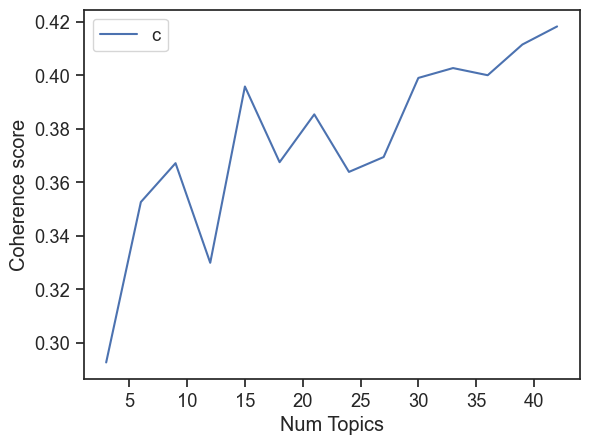

In [23]:
limit=45; start=3; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### We now can compute the gensim LDA model with the optimal number of topics

In [24]:
x_list= list(x)
best_num_topics_left_lda = x_list[np.argmax(coherence_values)]
lda_model_left = LdaModel(corpus=corpus_left, id2word=dictionary_left, num_topics=best_num_topics_left_lda, passes=10, random_state=42)
for idx, topic in lda_model_left.print_topics(-1):
    print(f"Topic {idx}: {topic}")


Topic 0: 0.103*"giorno" + 0.041*"patrimoniale" + 0.035*"quirinale" + 0.031*"proposta" + 0.029*"presidente" + 0.029*"popolare" + 0.029*"drammatico" + 0.025*"ogni" + 0.024*"grande" + 0.024*"iniziativa"
Topic 1: 0.065*"Roma" + 0.045*"programma" + 0.032*"rifiuto" + 0.027*"fiducia" + 0.025*"democratico" + 0.023*"poco" + 0.022*"terzo" + 0.020*"termovalorizzatore" + 0.019*"profondo" + 0.019*"recovery"
Topic 2: 0.141*"cosa" + 0.070*"nulla" + 0.064*"due" + 0.034*"lega" + 0.031*"regione" + 0.022*"settimana" + 0.021*"anno" + 0.021*"diverso" + 0.017*"dopo" + 0.016*"scorso"
Topic 3: 0.107*"scuola" + 0.053*"candidato" + 0.045*"pubblico" + 0.038*"scelta" + 0.036*"società" + 0.034*"dibattito" + 0.033*"unico" + 0.028*"proprio" + 0.018*"investimento" + 0.017*"tutto"
Topic 4: 0.066*"campagna" + 0.055*"elettorale" + 0.039*"giornalista" + 0.027*"violenza" + 0.027*"differenza" + 0.022*"ogni" + 0.022*"alleanza" + 0.021*"sovranista" + 0.020*"politico" + 0.019*"salare"
Topic 5: 0.080*"ora" + 0.062*"vita" + 0.0

### Let's see a representation of our topics

In [25]:
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_left'+str(best_num_topics_left_lda))

if 1 == 1:
    LDAvis_prepared_left = gensimvis.prepare(lda_model_left, corpus_left, dictionary_left)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared_left, f)

with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared_left, './results/ldavis_prepared_left'+ str(best_num_topics_left_lda) +'.html')

LDAvis_prepared_left

/Users/filippofocaccia/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/filippofocaccia/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/filippofocaccia/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/filippofocaccia/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/filippofocaccia/anaconda3/lib/python3.11/site-packages/pandas/cor

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
29    -0.228647 -0.086468       1        1  4.525449
39    -0.211999 -0.025223       2        1  4.057591
35    -0.170867 -0.101300       3        1  3.739258
31    -0.058256  0.218752       4        1  3.374631
2     -0.133657  0.064001       5        1  3.315222
11    -0.133744 -0.056771       6        1  2.899872
32    -0.093916  0.093900       7        1  2.859730
21    -0.004900  0.138580       8        1  2.744451
13     0.066153 -0.119220       9        1  2.686672
4     -0.046260 -0.046896      10        1  2.675414
33    -0.023218 -0.042136      11        1  2.675177
12    -0.042938 -0.158572      12        1  2.648098
19     0.019846 -0.020233      13        1  2.638544
1     -0.001881  0.151419      14        1  2.599922
41    -0.050315  0.118557      15        1  2.519860
5     -0.032200 -0.069284      16        1  2.512814
22    -0.038290  0.075189      17        1  2.497432
27     0.086183 -0.065961      18        1  2.428555
20     0.027031 -0.030485      19        1  2.395143
0     -0.031157  0.020564      20        1  2.355613
3      0.003644 -0.055704      21        1  2.322042
14    -0.070611  0.029915      22        1  2.313625
25     0.050762 -0.068546      23        1  2.247705
15     0.017291  0.049853      24        1  2.247484
40     0.068507 -0.034925      25        1  2.181726
10     0.018717 -0.003243      26        1  2.144720
6     -0.038783 -0.026297      27        1  2.135625
18     0.033378  0.060689      28        1  2.082398
17     0.020098  0.007542      29        1  1.962945
30     0.087048  0.039514      30        1  1.874187
38     0.069635  0.039638      31        1  1.867470
16     0.046779  0.029787      32        1  1.788903
8      0.036596 -0.040858      33        1  1.768550
37     0.048130  0.033959      34        1  1.760335
28     0.112343 -0.036780      35        1  1.746239
26     0.069473 -0.032793      36        1  1.714476
7      0.094671  0.023638      37        1  1.666186
23     0.079178  0.050819      38        1  1.643412
24     0.111856 -0.047676      39        1  1.631855
34     0.072512 -0.020954      40        1  1.604695
36     0.052694 -0.049419      41        1  1.591352
9      0.119119 -0.006572      42        1  1.554623, topic_info=         Term        Freq       Total Category  logprob  loglift
257    lavoro  738.000000  738.000000  Default  30.0000  30.0000
416     drago  624.000000  624.000000  Default  29.0000  29.0000
45    diritto  518.000000  518.000000  Default  28.0000  28.0000
283      cosa  714.000000  714.000000  Default  27.0000  27.0000
308    destra  518.000000  518.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
1071     nero   18.822256   30.244010  Topic42  -4.5428   3.6897
42      tempo   20.226936  290.841026  Topic42  -4.4708   1.4982
123   litalia   18.985026  320.975969  Topic42  -4.5342   1.3362
155     paese   18.539288  789.901017  Topic42  -4.5579   0.4119
859   giovane   13.880919  273.429587  Topic42  -4.8473   1.1834

[1989 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0        12  0.994035       \n\n 
4986     28  0.950967       \n \n
597       3  0.805826        \n  
597      25  0.166723        \n  
377      35  0.977574        \n\n
...     ...       ...         ...
890      18  0.906853         zan
1005     14  0.963245        zero
3638     21  0.943059  zingaretto
3259     18  0.948098       zitto
1878     15  0.968302        zona

[3283 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[30, 40, 36, 32, 3, 12, 33, 22, 14, 5, 34, 13, 20, 2, 42, 6, 23, 28, 21, 1, 4, 15, 26, 16, 41, 11, 7, 19, 18, 31, 39, 17, 9, 38, 29, 27, 8, 24, 25, 35, 37, 10])

### MALLET approach


In [ ]:
output_directory_left = '/Users/filippofocaccia/Desktop/nlp-project/politicians_data/politicians_filtered_left'
left_wing['processed_tweet_MALLET']=left_wing['processed_tweet'].apply(lambda x: ' '.join(x))
data_mallet_left= [t for t in left_wing['processed_tweet_MALLET'].tolist()]


### As done before we find the optimal number of topics through coherence computation and then se the specific topics for that number and finally see each tweet assignment to each topic

In [ ]:
num_topics_list, coherence_scores = find_optimal_topics(
    MALLET_path,
    output_directory_left,
    data_mallet_left,
    topic_range=(3, 40, 5),
    coherence_type='c_v',
    top_n=10
)


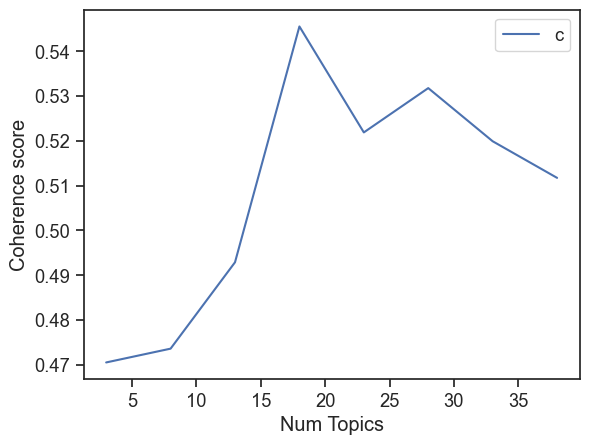

In [28]:
plt.plot(num_topics_list, coherence_scores)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_scores"), loc='best')
plt.show()

In [29]:

best_num_topics_MALLET_left= num_topics_list[coherence_scores.index(max(coherence_scores))]

In [30]:
topic_keys_left, topic_distributions_left = lmw.quick_train_topic_model(MALLET_path,
                                                                        output_directory, 
                                                                        best_num_topics_MALLET_left, 
                                                                        data_mallet_left)

Importing data...
Complete
Training topic model...


Mallet LDA: 18 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 33
total tokens: 112395
<10> LL/token: -9,62726
<20> LL/token: -9,32972
<30> LL/token: -9,19729
<40> LL/token: -9,12695

0	0,27778	guerra russo europeo Italia Putin sostegno Ucraina arma pieno internazionale ora militare ministro italiano governodrago necessario litalia inaccettabile collega momento 
1	0,27778	scuola cultura ragazzo storia anno tanto studente famiglia pensiero bello politico coloro vero giovane insulto storico ogni vita perché quartiere 
2	0,27778	drago sinistraitaliano giorno destra voto contrario senza partito coalizione quirinale due patto leader litalia fratoianni nessuno elezione posizione Italia responsabilità 
3	0,27778	nuovo impresa lavoratore governo grazie famiglia lavoro gas altro prezzo casa nazionale energia italiano crisi Italia azienda primo energetico Russia 
4	0,27778	cosa politica conte governo nulla maio persona due campo chiaro scelta voto paese storia giusto secondo poli

Complete


Left-Wing Italian Political Discourse: Three Major Narratives
-    International Relations and Progressive Values
    This narrative weaves together concerns about the "guerra" (war) in "Ucraina" (Ukraine) and "Russia," with left-wing politicians advocating for "pace" (peace) while maintaining "sostegno" (support) through "diplomazia" (diplomacy). The humanitarian dimension focuses on "migranti" (migrants), addressing "tragedie" (tragedies) in the Mediterranean involving people fleeing from "Libia" (Libya), framed through appeals to "solidarietà" (solidarity) and "diritti umani" (human rights).
    These international concerns connect to fundamental values of "libertà" (freedom), "democrazia" (democracy), and "diritti" (rights) within Italian society. The discourse highlights "donna" (women) and gender equality, often linked to historical "resistenza" (resistance) and anti-"mafia" struggles. This creates a narrative connecting progressive politics with Italy's fight against authoritarianism.
    The "europeo" (European) dimension positions Italy within a democratic "Europe," standing against authoritarian figures like "Putin" while advocating for collective action on shared challenges. Words like "valore" (value), "dovere" (duty), and "principio" (principle) permeate this discourse, framing political choices as moral imperatives.
    
- Economic and Social Policy
    This narrative addresses "crisi" (crisis) affecting "famiglie" (families) and "imprese" (businesses), particularly regarding "bollette" (utility bills), "costo" (costs), and "gas" prices. Left-wing politicians propose interventionist measures like "tetto" (price caps), government "intervento" (intervention), and "decreti" (decrees) to protect vulnerable citizens.
    The "pandemia" (pandemic) has shaped discourse around "sanità" (healthcare), "vaccini" (vaccines), and balancing public health with "scuola" (education). This connects to arguments for strengthening "pubblico" (public) services and the welfare state.
    "Lavoro" (work) and worker rights form a cornerstone, with calls for "salario minimo" (minimum wage), "reddito" (income) protections, and more progressive "tasse" (taxes) to address inequality. "Cultura" (culture), "musei" (museums), and "teatro" (theater) are framed not merely as heritage but as vital social assets.
    The narrative emphasizes future "investimenti" (investments) in renewable "energia" (energy), youth "opportunità" (opportunities), and "sociale" (social) programs through "PNRR" (National Recovery and Resilience Plan) and European funding. Terms like "futuro" (future), "piano" (plan), and "programma" (program) signal a forward-looking approach to building a more equitable society.

- Governance and Political Positioning
    This narrative defines left-wing identity against the "destra" (right), with "antifascismo" (anti-fascism) serving as both historical reference and contemporary boundary. Left politicians oppose normalization of far-right ideologies in "stampa" (press), "scuola" (schools), and public discourse.
    "Elezioni" (elections) feature prominently, with discussions of "candidati" (candidates), "coalizione" (coalition), and "primarie" (primaries). Left politicians criticize right-wing leaders like "Meloni," "Salvini," and "Berlusconi," often drawing parallels to international figures like "Trump."
    The discourse includes reflections on "politica" (politics) itself, with the "sinistra" (left) positioning itself against "populismo" (populism). Terms like "serio" (serious) and "responsabile" (responsible) characterize the self-image of left parties as alternatives to right-wing governance.
    "Roma" city management highlights issues like "rifiuti" (waste), "servizi" (services), and "quartieri" (neighborhoods), while broader "governo" (government) discussions address "parlamento" (parliament), "presidente" (president), and the "Quirinale" (presidential palace politics).
    Throughout runs an aspirational tone about "cittadini" (citizens), "futuro" (future), and "importanza" (importance) of good governance, balancing critique with an affirmative vision using words like "grazie" (thank you), "bello" (beautiful), and "buono" (good) to convey optimism about left-wing leadership possibilities

Category 1: International Relations and Progressive Values

- 0: War and diplomacy (Ukraine-Russia conflict, Putin, peace, European, arms, international relations, diplomatic support)
- 5: Migration and humanitarian concerns (migrants, families, victims, Libya, human rights, solidarity, tragedies)
- 7: Liberty and democratic principles (freedom, rights, democracy, duties, politics, society, liberalism, culture, values)
- 8: Solidarity and social justice (solidarity, women, liberty, rights, values, resistance, memory, anti-mafia stance)
- 11: European and international democracy (Europe, democracy, Ukraine, European integration, freedom)

Category 2: Economic and Social Policy
-  3: Economic crisis management (businesses, families, bills, government, costs, proposals, price caps, interventions)
-  6: COVID and healthcare (vaccines, COVID, schools, pandemic, public health, vaccination plans, health passes)
-  12: Labor rights and economic justice (work, workers, rights, laws, income, taxes, unions, youth, minimum wage)
-  14: Cultural development (culture, museums, history, youth, arts, theater, cultural heritage)
-  15: Future-oriented investments (proposals, youth, gas, European investments, schools, energy, public health, social programs)

Category 3: Governance and Political Positioning

-  1: Anti-fascism and education (government, parliament, left Italian, fascism, students, schools, press freedom)
- 2: Electoral politics (candidates, Conte, right, Rome, voting, coalitions, primaries, mayoral races)
- 4: Political discourse (politics, politicians, reasoning, country governance, approaches to issues)
- 9: Left vs. right political framing (politics, left, right, country, parties, serious politics, electoral proposals)
- 10: Opposition to right-wing leadership (leadership critique, Meloni, Salvini, Trump, Berlusconi, electoral concerns)
- 13: Positive governance messaging (gratitude, work, citizenship, mayors, city management, future planning)
- 16: Rome city management (Rome, waste management, municipal services, city programs, neighborhoods, capital city)
- 17: Government politics (government, parliament, president, Conte, political maneuvering, majority coalition, Quirinale)

In [ ]:
tweets_topics_df = format_topics_documents(topic_distributions_left, topic_keys_left, data_mallet_left, docs_metadata=None)
tweets_topics_df.to_csv('politicians_data/tweets_topics_df_left.csv', index=False)
tweets_topics_df.rename(columns={'Text_Sample': 'processed_tweet_MALLET'}, inplace=True)
tweets_topics_df = tweets_topics_df[['processed_tweet_MALLET', 'Dominant_Topic']]
left_wing['processed_tweet_MALLET']=left_wing['processed_tweet'].apply(lambda x: ' '.join(x))

In [115]:
left_wing_merged = pd.merge(left_wing, tweets_topics_df, on='processed_tweet_MALLET', how='inner')

In [74]:
topics_left= pd.DataFrame()
text={}
for i, t in enumerate(topic_keys_left):
    text[i] = ' '.join(t)
    print(i, '\t', text[i])

topics_left['TopicNumber'] = text.keys()
topics_left['TopicWords'] = text.values()
macros = {0: [0,5,7,8,11], 1: [3,6,12,14,15], 2: [1,2,4,9,10,16,17]}
topics=[' International Relations and Progressive Values',' Economic and Social Policy ','Governance and Political Positioning']
assigned_topics = []
for index,row in topics_right.iterrows():
    if index in macros[0]:
        assigned_topics.append(topics[0])
    elif index in macros[1]:
        assigned_topics.append(topics[1])
    else:
        assigned_topics.append(topics[2])
topics_left['MacroTopic'] = assigned_topics



0 	 guerra ucraino russo pace Putin europeo Ucraina arma Russia internazionale Italia paese estero italiano collega popolo sostegno governo diplomatico civile
1 	 governo parlamentare interrogazione ministro fascismo studente sinistraitaliano scuola parola vicenda destra perché consigliere organizzazione fascista ragazzo renzi lamorgese stampa giornalista
2 	 candidato maio destra conte Roma voto drago cosa raggio campo elettorale secondo primo fratoianni accordo collegio coalizione campagna primario sindaco
3 	 impresa famiglia bolletta governo prezzo euro costo tetto miliardo proposta nuovo intervento italiano crisi aumento anno altro gas cittadino azienda
4 	 cosa politica quando ogni politico persona ragione nulla senza altro anno giorno volta due parte fatto italiano paese modo molto
5 	 anno migrante famiglia italiano vittima dolore libico vita tragedia giustizia pensiero libia persona ora governo guardia illegale processo scomparsa umano
6 	 vaccino covid scuola pandemia sanità 